In [1]:
from dask.array.image import imread as imr
import os
import napari
import numpy as np
from skimage import io, data
from nucleiBoxes import getNucleiCoordinates, cropNuclei
import matplotlib.pyplot as plt
import math
import numpy.ma as ma
import pandas as pd

In [2]:
homeFolder = '/media/rachel/9d56c1ff-e031-4e35-9f3c-fcd7d3e80033/Analysis/20230720/'
nameKey = 'Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_10ng.ml_tnf_exp1_4_F'
imsQ = '11'
pathToTimeFrames = homeFolder+nameKey+imsQ+'/*.tif'
cellNumber = '1'
path_input = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/'
nucleiStackForm = nameKey+imsQ+"_cell_"
pathToTimeFramesCell = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/*.tif'
stackCell = imr(pathToTimeFramesCell)
MaxTimePoint = stackCell.shape[0]
timeStack = imr(pathToTimeFrames)
print(timeStack.shape)
maxImage = np.max(timeStack, axis=1)

(900, 13, 1024, 1024)


In [3]:
def getBackgroundTimeProfile(path_input, nameKey, imsQ, maxTimePoint, minc, minr, maxc, maxr):
    imagePath = moviePath
    meanofRandomImageSample = []
    timePoint = 0
    nucleiStackName = nameKey+imsQ+'_t'+str(f"{timePoint:03}")+".tif"
    nucleiStackPath = os.path.join(imagePath, nucleiStackName) 
    newimage = io.imread(nucleiStackPath)
    imageShape = np.shape(newimage)
    projectionNuclei = np.max(newimage, axis=0)
    cropBoxForIntensity = projectionNuclei[minr:maxr,minc:maxc]
    imageSampleMean = np.mean(cropBoxForIntensity)
    meanofRandomImageSample.append(imageSampleMean)
    for ii in range(1,maxTimePoint):
        timePoint = ii
        nucleiStackName =  nameKey+imsQ+'_t'+str(f"{timePoint:03}")+".tif"
        nucleiStackPath = os.path.join(imagePath, nucleiStackName)     
        newimage = io.imread(nucleiStackPath)
        projectionNuclei = np.max(newimage, axis=0)
        cropBoxForIntensity = projectionNuclei[minr:maxr,minc:maxc]
        imageSampleMean = np.mean(cropBoxForIntensity)
        meanofRandomImageSample.append(imageSampleMean)  
    return meanofRandomImageSample

In [38]:
def getTimeProfile(path_input,nucleiStackForm, maxTimePoint, cellNumber, label_image_name, labeldf):
    label_image = io.imread(label_image_name)
    nuclei=np.int64(cellNumber)
    nucIdx = np.where(labeldf['label']==np.int64(nuclei))
    minr = labeldf.loc[nucIdx]['minr'].values[0]
    minc = labeldf.loc[nucIdx]['minc'].values[0]
    sizex = np.int64(labeldf.loc[nucIdx]['sizex'].values[0])
    sizey = np.int64(labeldf.loc[nucIdx]['sizey'].values[0])
    nucleiMask = label_image[math.floor(minr):math.floor(minr)+sizex,math.floor(minc):math.floor(minc)+sizey]

    maskNum = np.unique(nucleiMask)
    maskNum = np.delete(maskNum,0)
    imagePath = path_input
    meanofRandomImageSample_within = []
    meanofRandomImageSample_outside = []

    timePoint = 0
    nucleiStackName =  nucleiStackForm+str(nuclei)+'_t'+str(f"{timePoint:03}")+".tif"
    nucleiStackPath = os.path.join(imagePath, nucleiStackName) 
    newimage = io.imread(nucleiStackPath)
    imageShape = np.shape(newimage)
    projectionNuclei = np.max(newimage, axis=0)
    withinNuc = ma.masked_where(nucleiMask!=maskNum, projectionNuclei)
    outsideNuc =  ma.masked_where(nucleiMask==maskNum, projectionNuclei)
    imageSampleMean_within = np.mean(withinNuc)
    imageSampleMean_outside = np.mean(outsideNuc)
    meanofRandomImageSample_within.append(imageSampleMean_within)
    meanofRandomImageSample_outside.append(imageSampleMean_outside)

    for ii in range(1,maxTimePoint):
        timePoint = ii
        nucleiStackName =  nucleiStackForm+str(nuclei)+'_t'+str(f"{timePoint:03}")+".tif"
        nucleiStackPath = os.path.join(imagePath, nucleiStackName)     
        newimage = io.imread(nucleiStackPath)
        imageShape = np.shape(newimage)
        projectionNuclei = np.max(newimage, axis=0)
        withinNuc = ma.masked_where(nucleiMask!=maskNum, projectionNuclei)
        outsideNuc =  ma.masked_where(nucleiMask==maskNum, projectionNuclei)
        imageSampleMean_within = np.mean(withinNuc)
        imageSampleMean_outside = np.mean(outsideNuc)
        meanofRandomImageSample_within.append(imageSampleMean_within)
        meanofRandomImageSample_outside.append(imageSampleMean_outside)   

    return meanofRandomImageSample_within, meanofRandomImageSample_outside

In [5]:
label_image_name = '/media/rachel/9d56c1ff-e031-4e35-9f3c-fcd7d3e80033/Analysis/20230720/tProjections/Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_10ng_ml_tnf_exp1_4_F11_cp_masks.png'
label_image = io.imread(label_image_name)
print(label_image_name)

/media/rachel/9d56c1ff-e031-4e35-9f3c-fcd7d3e80033/Analysis/20230720/tProjections/Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_10ng_ml_tnf_exp1_4_F11_cp_masks.png


/home/rachel/anaconda3/envs/imageAnalysis_2/lib/python3.8/site-packages/imageio/plugins/pillow.py:297: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


In [6]:
cropBoxCoordinates, nucleiCentroids, nucleiNumbers, _ = getNucleiCoordinates(label_image_name, False)

polygon = []
for nuclei in range(len(cropBoxCoordinates)):
    bx = np.asarray(cropBoxCoordinates[nuclei][0])
    by = np.asarray(cropBoxCoordinates[nuclei][1])
    vertices = []
    for ii in range(len(bx)):
        vertices.append([by[ii], bx[ii]])
    polygon.append(vertices)

features = {
    'N': nucleiNumbers,
    #'good_point': np.array([True, False, False]),
}
text = {
    'string': '{N:.1f}',
    'size': 8,
    'color': 'white',
    'translation': np.array([-20, 0]),
}

face_color_cycle = ['white']
# create a points layer where the face_color is set by the good_point feature
# and the edge_color is set via a color map (grayscale) on the confidence
# feature.



In [7]:
viewer = napari.view_image(maxImage, colormap='green')
labels_layer = viewer.add_labels(label_image, name='segmentation',opacity=0.3)
shapes_layer = viewer.add_shapes(polygon, shape_type='polygon', edge_width=2,
                          edge_color='white', face_color='#00000000', opacity=0.3)
points_layer = viewer.add_points(
    nucleiCentroids,
    features=features,
    text=text,
    size=2,
    edge_width=2,
    edge_width_is_relative=False,
    edge_color='N',
    edge_colormap='gray',
    face_color_cycle=face_color_cycle,
    name = 'nuclei Label'
)

In [8]:
# Get background

random_box = shapes_layer.data[-1]

In [9]:
coord=[]
minc = int(np.round(random_box[0][1]))
minr = int(np.round(random_box[0][0]))
maxc = int(np.round(random_box[2][1]))
maxr = int(np.round(random_box[2][0]))

bx = (minc, maxc, maxc, minc, minc)
by = (minr, minr, maxr, maxr, minr)
coord.append([bx, by, minc,minr])
#

In [10]:
moviePath = homeFolder+nameKey+imsQ+'/'
test = getBackgroundTimeProfile(moviePath, nameKey, imsQ, MaxTimePoint, minc, minr, maxc, maxr)

/home/rachel/anaconda3/envs/imageAnalysis_2/lib/python3.8/site-packages/imageio/plugins/pillow.py:297: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(
/tmp/ipykernel_96232/4179708123.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-b" (-> color='b'). The keyword argument will take precedence.
  plt.plot(bx, by, '-b', linewidth=.7, color='yellow')


Text(0.5, 1.0, 'Mean intensity over time')

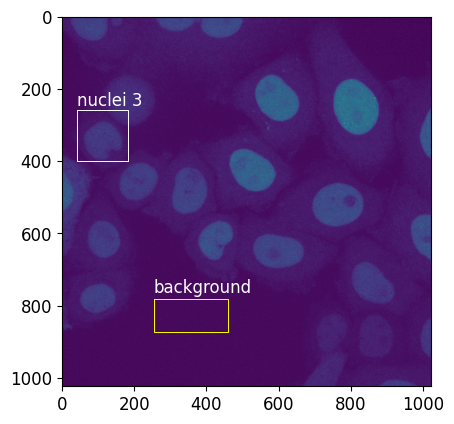

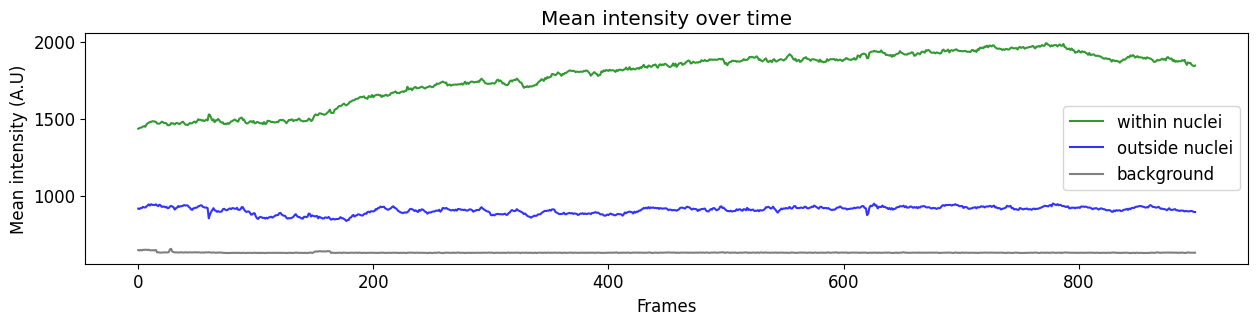

In [44]:
cellNumber=3
plt.rcParams['font.size'] = 12
t=0
path_input ='/media/rachel/9d56c1ff-e031-4e35-9f3c-fcd7d3e80033/Analysis/20230720/'+nameKey+imsQ+'/cell_'+str(cellNumber)+'/'
nucleiStackForm = nameKey+imsQ+"_cell_"
nucleiStackName = nucleiStackForm+str(cellNumber)+'_t'+str(f"{t:03}")+".tif"
nucleiStackPath = os.path.join(path_input, nucleiStackName)
labeldf = pd.read_pickle(moviePath+"LabelDF.pkl")  
maxTimePoint = MaxTimePoint
meanofRandomImageSample =[]


meanofRandomImageSample =[]
path_input ='/media/rachel/9d56c1ff-e031-4e35-9f3c-fcd7d3e80033/Analysis/20230720/'+nameKey+imsQ+'/cell_'+str(cellNumber)+'/'

meanofRandomImageSample_w, meanofRandomImageSample_o = getTimeProfile(path_input, nucleiStackForm, maxTimePoint, cellNumber, label_image_name, labeldf)
meanofRandomImageSample.append(meanofRandomImageSample_w)
meanofRandomImageSample.append(meanofRandomImageSample_o)
meanofRandomImageSample = np.asarray(meanofRandomImageSample)

nucIdx = np.where(labeldf['label']==np.int64(cellNumber))
minr = labeldf.loc[nucIdx]['minr'].values[0]
minc = labeldf.loc[nucIdx]['minc'].values[0]
maxr = labeldf.loc[nucIdx]['maxr'].values[0]
maxc = labeldf.loc[nucIdx]['maxc'].values[0]

plt.figure(num=25)
plt.imshow(maxImage[0])
newimage = io.imread(nucleiStackPath)
projectionNuclei = np.max(newimage, axis=0)
plt.plot((minc, maxc, maxc, minc, minc), (minr, minr, maxr, maxr, minr), '-w', linewidth=.7)

plt.text(coord[0][0][0],coord[0][1][1]*0.98, s='background', color='white')
plt.plot(bx, by, '-b', linewidth=.7, color='yellow')
plt.text(minc, minr*0.95, s='nuclei '+str(cellNumber), color='white')
percentageLoss = ((np.mean(meanofRandomImageSample,axis=0)[0]-np.mean(meanofRandomImageSample,axis=0)[-1])/np.mean(meanofRandomImageSample,axis=0)[0])*100

plt.figure(num=4, figsize=(15,3))
plt.plot(meanofRandomImageSample[0],  label='within nuclei', color='green', alpha=0.8)
plt.plot(meanofRandomImageSample[1],  label='outside nuclei', color='blue', alpha=0.8)


plt.plot(test, label= 'background', color='grey')
plt.legend(labelcolor='black')
plt.xlabel('Frames')
plt.ylabel('Mean intensity (A.U)')
plt.title('Mean intensity over time')

In [36]:
cellNumber

1